# MS019 Preprocess
Created: 01/25/2024 \
Updated: 04/07/2024

In [1]:
import numpy as np
import mne
from glob import glob
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
from scipy.stats import zscore, linregress, ttest_ind, ttest_rel, ttest_1samp
import pandas as pd
from mne.preprocessing.bads import _find_outliers
import os 
import joblib
import re
import datetime
import scipy


import warnings
warnings.filterwarnings('ignore')

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys
sys.path.append('/sc/arion/projects/guLab/Alie/SWB/ephys_analysis/LFPAnalysis/')

In [4]:
from LFPAnalysis import lfp_preprocess_utils, sync_utils, analysis_utils, nlx_utils

In [5]:
# Specify root directory for un-archived data and results 
base_dir = '/sc/arion/projects/guLab/Alie/SWB/'
anat_dir = f'{base_dir}ephys_analysis/recon_labels/'
neural_dir = f'{base_dir}ephys_analysis/data/'
behav_dir = f'{base_dir}swb_behav_models/data/behavior_preprocessed/'

subj_id = 'MS019'
subj_format = ['edf']
subj_site = ['MSSM']


# Make mne_data


### Load and resample data


In [6]:
edf_files = glob(f'{neural_dir}{subj_id}/raw/*.edf')

mne_data = mne.io.read_raw_edf(edf_files[0], preload=True)


Extracting EDF parameters from /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS019/raw/MS019_SWB.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 2175999  =      0.000 ...  2124.999 secs...


In [7]:
mne_data

<RawEDF | MS019_SWB.edf, 276 x 2176000 (2125.0 s), ~4.47 GB, data loaded>

In [8]:
# mne_data.ch_names

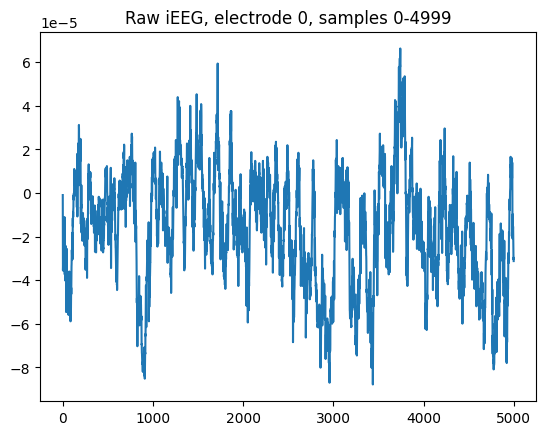

In [8]:
# Sanity check one channel data

plt.plot(mne_data._data[0,:4999])
plt.title("Raw iEEG, electrode 0, samples 0-4999")
plt.show()

### Resampling data 

In [8]:
#resampling if patient is not sampled at 512
resample_sr = 500
mne_data.resample(sfreq=resample_sr, npad='auto', n_jobs=-1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:   14.6s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:   29.5s
[Parallel(n_jobs=-1)]: Done 276 out of 276 | elapsed:   45.4s finished


<RawEDF | MS019_SWB.edf, 276 x 1062500 (2125.0 s), ~2.19 GB, data loaded>

### Photodiode
- examine photodiode 

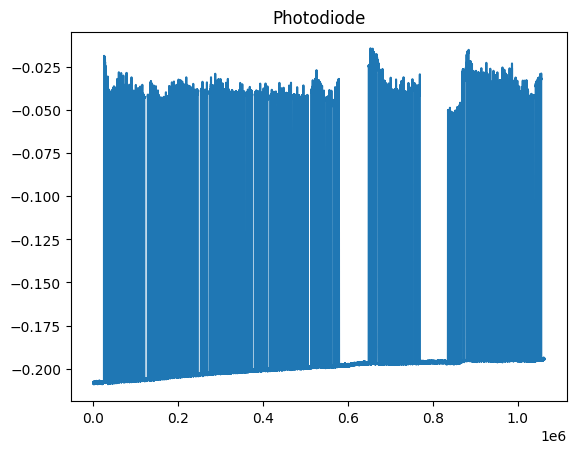

In [9]:
# Sanity check the photodiode
trig_ix = mne_data.ch_names.index("DC1")
plt.plot(mne_data._data[trig_ix])
plt.title("Photodiode")
plt.show()

In [10]:
mne_data.save(f'{neural_dir}{subj_id}/photodiode.fif', picks='DC1', overwrite=True)

Overwriting existing file.
Writing /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS019/photodiode.fif
Closing /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS019/photodiode.fif
[done]


In [11]:
mne_data.drop_channels(['DC1'])

<RawEDF | MS019_SWB.edf, 275 x 1062500 (2125.0 s), ~2.18 GB, data loaded>

### Notch filter line noise

In [12]:
mne_data.info['line_freq'] = 60
# Notch out 60 Hz noise and harmonics 
mne_data.notch_filter(freqs=(60, 120, 180, 240))

Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 3301 samples (6.602 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 275 out of 275 | elapsed:    9.2s finished


<RawEDF | MS019_SWB.edf, 275 x 1062500 (2125.0 s), ~2.18 GB, data loaded>

### Anatomical Localization

In [13]:
### Rename channels to be lowercase before anatomical localization
new_name_dict = {x:x.replace(" ", "").lower() for x in mne_data.ch_names}
mne_data.rename_channels(new_name_dict)

<RawEDF | MS019_SWB.edf, 275 x 1062500 (2125.0 s), ~2.18 GB, data loaded>

In [14]:
# Load the electrode localization data
anat_file = glob(f'{anat_dir}{subj_id}_labels.csv')[0]
elec_locs = pd.read_csv(anat_file)
# Sometimes there's extra columns with no entries: 
elec_locs = elec_locs[elec_locs.columns.drop(list(elec_locs.filter(regex='Unnamed')))]

elec_locs

,label,BN246label,x,y,z,mni_x,mni_y,mni_z,gm,NMM,Anat,AnatMacro,BN246,YBA_1,ManualExamination,Notes
0,LaCaS1,A32sg_L,-2.795636,34.346371,5.999996,-2.570422,27.802347,-5.413951,Gray,Left ACgG anterior cingulate gyrus,Area s24,L ACC,L CG,Left cingulate gyrus C,NaN,NaN
1,LaCaS10,A9l_L,-11.581916,56.312073,43.999994,-12.306464,60.493542,33.029109,Gray,Left SFG superior frontal gyrus,Unknown,L Superior Frontal Gyrus,L SFG,Left superior frontal gyrus 1 D,NaN,NaN
2,LaCaS11,Unknown,-12.380669,59.107707,48.399994,-13.320612,64.809729,37.490489,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,OOB,NaN
3,LaCaS12,Unknown,-13.179422,60.305837,51.199993,-14.276922,66.898697,40.415833,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,OOB,NaN
4,LaCaS2,A32sg_L,-3.594388,36.742630,9.999996,-3.429509,31.395072,-1.489375,Gray,Left ACgG anterior cingulate gyrus,Area 33,L ACC,L CG,Left cingulate gyrus D,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
167,RsPpC7,A7ip_R,25.160712,-45.129531,35.999994,26.390526,-50.717179,46.775628,Gray,Right SPL superior parietal lobule,Unknown,Unknown,R SPL,Right superior parietal 2 D,WM,NaN
168,RsPpC8,A7ip_R,28.755099,-47.525789,39.199994,30.549717,-52.507090,50.966902,Gray,Right SPL superior parietal lobule,Area hIP3 (IPS),R Inferior Parietal Lobule,R SPL,Right superior parietal 2 D,NaN,NaN
169,RsPpC9,A7ip_R,32.349487,-49.522671,41.999994,34.673166,-54.045856,54.610691,Gray,Right SPL superior parietal lobule,Area hIP3 (IPS),R Inferior Parietal Lobule,R SPL,Right superior parietal 2 D,NaN,NaN
170,uLmOIF,A13_L,-4.792518,37.940759,-4.800003,-4.177642,28.423886,-18.311256,Gray,Left MFC medial frontal cortex,Area s32,L Rectal Gyrus,L OrG,Left frontal pole 1 B,NaN,NaN


In [15]:
list(elec_locs.label)

['LaCaS1',
 'LaCaS10',
 'LaCaS11',
 'LaCaS12',
 'LaCaS2',
 'LaCaS3',
 'LaCaS4',
 'LaCaS5',
 'LaCaS6',
 'LaCaS7',
 'LaCaS8',
 'LaCaS9',
 'LAgIT1',
 'LAgIT10',
 'LAgIT2',
 'LAgIT3',
 'LAgIT4',
 'LAgIT5',
 'LAgIT6',
 'LAgIT7',
 'LAgIT8',
 'LAgIT9',
 'LHpIT1',
 'LHpIT10',
 'LHpIT2',
 'LHpIT3',
 'LHpIT4',
 'LHpIT5',
 'LHpIT6',
 'LHpIT7',
 'LHpIT8',
 'LHpIT9',
 'LiITO1',
 'LiITO2',
 'LiITO3',
 'LiITO4',
 'LiITO5',
 'LiITO6',
 'LiITO7',
 'LiITO8',
 'LmCmS1',
 'LmCmS10',
 'LmCmS2',
 'LmCmS3',
 'LmCmS4',
 'LmCmS5',
 'LmCmS6',
 'LmCmS7',
 'LmCmS8',
 'LmCmS9',
 'LmOIF1',
 'LmOIF2',
 'LmOIF3',
 'LmOIF4',
 'LmOIF5',
 'LmOIF6',
 'LmOIF7',
 'LmOIF8',
 'LmOIF9',
 'LpIOC1',
 'LpIOC10',
 'LpIOC11',
 'LpIOC12',
 'LpIOC13',
 'LpIOC14',
 'LpIOC2',
 'LpIOC3',
 'LpIOC4',
 'LpIOC5',
 'LpIOC6',
 'LpIOC7',
 'LpIOC8',
 'LpIOC9',
 'LsPpC1',
 'LsPpC10',
 'LsPpC11',
 'LsPpC12',
 'LsPpC2',
 'LsPpC3',
 'LsPpC4',
 'LsPpC5',
 'LsPpC6',
 'LsPpC7',
 'LsPpC8',
 'LsPpC9',
 'RaCaS1',
 'RaCaS10',
 'RaCaS11',
 'RaCaS12',
 'Ra

In [16]:
anat_names = list(elec_locs.label.str.lower())
sum([ch not in mne_data.ch_names for ch in anat_names]) #if there are no missing channels, sum = 0. if sum >0, find the missing elecs
print([ch for ch in mne_data.ch_names if ch not in anat_names ]) #print extra channels in mne_data.ch_names and make sure none of them are neural channels (will be EEG etc.)

['lmolf1', 'lmolf2', 'lmolf3', 'lmolf4', 'lmolf5', 'lmolf6', 'lmolf7', 'lmolf8', 'lmolf9', 'rmolf1', 'rmolf2', 'rmolf3', 'rmolf4', 'rmolf5', 'rmolf6', 'rmolf7', 'rmolf8', 'rmolf9', 'c63', 'c64', 'lilto1', 'lilto2', 'lilto3', 'lilto4', 'lilto5', 'lilto6', 'lilto7', 'lilto8', 'rilto1', 'rilto2', 'rilto3', 'rilto4', 'rilto5', 'rilto6', 'rilto7', 'rilto8', 'laglt1', 'laglt2', 'laglt3', 'laglt4', 'laglt5', 'laglt6', 'laglt7', 'laglt8', 'laglt9', 'laglt10', 'raglt1', 'raglt2', 'raglt3', 'raglt4', 'raglt5', 'raglt6', 'raglt7', 'raglt8', 'raglt9', 'raglt10', 'c125', 'c126', 'c127', 'c128', 'lhplt1', 'lhplt2', 'lhplt3', 'lhplt4', 'lhplt5', 'lhplt6', 'lhplt7', 'lhplt8', 'lhplt9', 'lhplt10', 'rhplt1', 'rhplt2', 'rhplt3', 'rhplt4', 'rhplt5', 'rhplt6', 'rhplt7', 'rhplt8', 'rhplt9', 'rhplt10', 'lploc1', 'lploc2', 'lploc3', 'lploc4', 'lploc5', 'lploc6', 'lploc7', 'lploc8', 'lploc9', 'lploc10', 'lploc11', 'lploc12', 'lploc13', 'lploc14', 'rploc1', 'rploc2', 'rploc3', 'rploc4', 'rploc5', 'rploc6', 'rpl

In [17]:
new_mne_names, unmatched_names, unmatched_seeg = lfp_preprocess_utils.match_elec_names(mne_data.ch_names, elec_locs.label)


Number of electrodes in the mne file is greater than the number of electrodes in the localization file


In [18]:
unmatched_seeg #make sure there are no unmatched names


[]

In [19]:
new_name_dict = {x:y for (x,y) in zip(mne_data.ch_names, new_mne_names)}


In [20]:
new_name_dict #make sure this passes the eye test 


{'lmolf1': 'lmoif1',
 'lmolf2': 'lmoif2',
 'lmolf3': 'lmoif3',
 'lmolf4': 'lmoif4',
 'lmolf5': 'lmoif5',
 'lmolf6': 'lmoif6',
 'lmolf7': 'lmoif7',
 'lmolf8': 'lmoif8',
 'lmolf9': 'lmoif9',
 'rmolf1': 'rmoif1',
 'rmolf2': 'rmoif2',
 'rmolf3': 'rmoif3',
 'rmolf4': 'rmoif4',
 'rmolf5': 'rmoif5',
 'rmolf6': 'rmoif6',
 'rmolf7': 'rmoif7',
 'rmolf8': 'rmoif8',
 'rmolf9': 'rmoif9',
 'lacas1': 'lacas1',
 'lacas2': 'lacas2',
 'lacas3': 'lacas3',
 'lacas4': 'lacas4',
 'lacas5': 'lacas5',
 'lacas6': 'lacas6',
 'lacas7': 'lacas7',
 'lacas8': 'lacas8',
 'lacas9': 'lacas9',
 'lacas10': 'lacas10',
 'lacas11': 'lacas11',
 'lacas12': 'lacas12',
 'racas1': 'racas1',
 'racas2': 'racas2',
 'racas3': 'racas3',
 'racas4': 'racas4',
 'racas5': 'racas5',
 'racas6': 'racas6',
 'racas7': 'racas7',
 'racas8': 'racas8',
 'racas9': 'racas9',
 'racas10': 'racas10',
 'racas11': 'racas11',
 'racas12': 'racas12',
 'lmcms1': 'lmcms1',
 'lmcms2': 'lmcms2',
 'lmcms3': 'lmcms3',
 'lmcms4': 'lmcms4',
 'lmcms5': 'lmcms5',
 

In [21]:
# Rename the mne data according to the localization data

mne_data.rename_channels(new_name_dict)

<RawEDF | MS019_SWB.edf, 275 x 1062500 (2125.0 s), ~2.18 GB, data loaded>

In [22]:
right_seeg_names = [i for i in mne_data.ch_names if i.startswith('r')]
left_seeg_names = [i for i in mne_data.ch_names if i.startswith('l')]
print(f'We have a total of {len(left_seeg_names)} left sEEG and {len(right_seeg_names)} right sEEG electrodes')
print(f'We have a total of {len(left_seeg_names) + len(right_seeg_names)} sEEG electrodes')



We have a total of 85 left sEEG and 85 right sEEG electrodes
We have a total of 170 sEEG electrodes


In [23]:
sEEG_mapping_dict = {f'{x}':'seeg' for x in left_seeg_names+right_seeg_names}
mne_data.set_channel_types(sEEG_mapping_dict)


<RawEDF | MS019_SWB.edf, 275 x 1062500 (2125.0 s), ~2.18 GB, data loaded>

In [24]:
drop_chans = list(set(mne_data.ch_names)^set(left_seeg_names+right_seeg_names))
mne_data.drop_channels(drop_chans) #number of chans should = number of seegs 

<RawEDF | MS019_SWB.edf, 170 x 1062500 (2125.0 s), ~1.35 GB, data loaded>

In [25]:
# make montage (convert mm to m)

montage = mne.channels.make_dig_montage(ch_pos=dict(zip(elec_locs.label, 
                                                        elec_locs[['mni_x', 'mni_y', 'mni_z']].to_numpy(dtype=float)/1000)),
                                        coord_frame='mni_tal')

mne_data.set_montage(montage, match_case=False, on_missing='warn')

<RawEDF | MS019_SWB.edf, 170 x 1062500 (2125.0 s), ~1.35 GB, data loaded>

## Signal Cleaning 
Methods:
- Use manual bad channel detection for **bipolar** referencing
    - bipolar referencing completely ignores channels labeled as 'bad' so do not remove unless absolutely necessary
    - remove ch if there is massive artifact in a channel not in the rest of probe 
    - if entire probe shows same artifact try to keep
- Remove additional channels as needed
- This process is iterative depending on how TFRs look. 

In [27]:
#this is just for my own personal info and to select how many channels to visualize at a time
ch_names = list(elec_locs.label.str.lower())
pattern = '[0-9]'
ch_names_no_num = [re.sub(pattern, '', i) for i in ch_names]
probe_names = np.unique(ch_names_no_num)
# probe_names

In [28]:
probe_ch_counts = {} #need this to select channel number for visualization
for p in probe_names:
    c = ch_names_no_num.count(p)
    probe_ch_counts[p] = c

In [29]:
probe_ch_counts

{'lacas': 12,
 'lagit': 10,
 'lhpit': 10,
 'liito': 8,
 'lmcms': 10,
 'lmoif': 9,
 'lpioc': 14,
 'lsppc': 12,
 'racas': 12,
 'ragit': 10,
 'rhpit': 10,
 'riito': 8,
 'rmcms': 10,
 'rmoif': 9,
 'rpioc': 14,
 'rsppc': 12,
 'ulmoif': 1,
 'urmoif': 1}

### Compare auto detection result to actual lfp data - if trusted save auto result as mne bads
- often inaccurate - verify that all included channels make sense and all channels that should be included are
- take out any crazy noise, especially if it's only in one channel on probe (won't be cancelled out)

In [30]:
# mne_data.info['bads'] = lfp_preprocess_utils.detect_bad_elecs(mne_data, sEEG_mapping_dict) #this is likely inaccurate - just use to get an idea 
lfp_preprocess_utils.detect_bad_elecs(mne_data, sEEG_mapping_dict)

['lpioc14',
 'lpioc2',
 'lpioc3',
 'riito5',
 'riito6',
 'riito7',
 'rmoif1',
 'rsppc5',
 'rsppc7',
 'rsppc8']

<IPython.core.display.Javascript object>


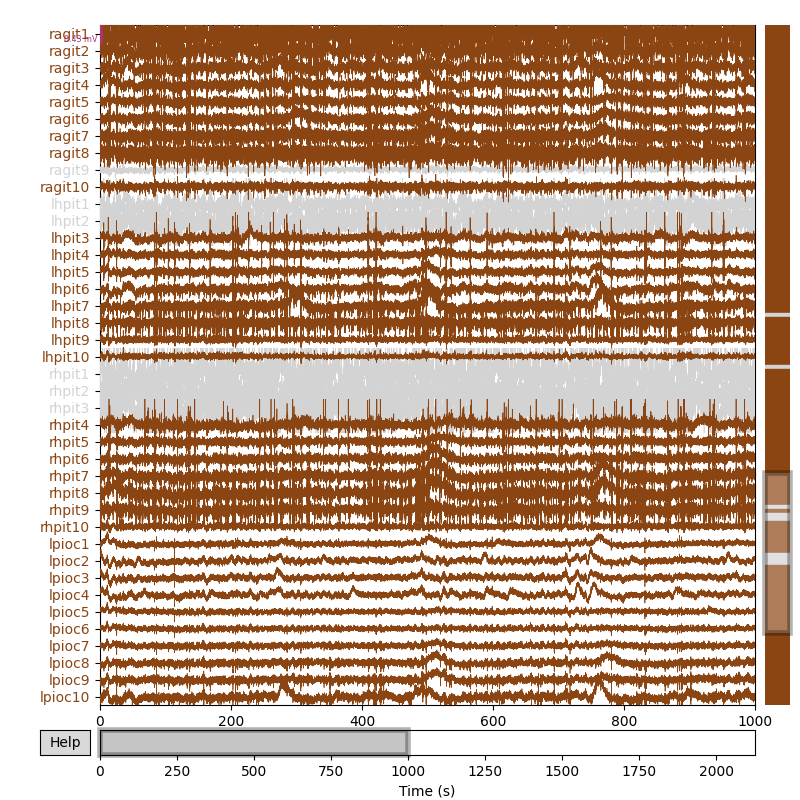

In [40]:
 %matplotlib notebook
fig = mne_data.plot(start=0, duration=1000, n_channels=40, scalings=mne_data._data.max()/50)


In [31]:
# mne_data.info['bads'] = ['lacas10',
#  'lacas11',
#  'lacas12',
#  'rsppc12',
#  'lsppc11',
#  'lsppc12',
#  'lagit1',
#  'ragit1',
#  'ragit2',
#  'ragit9',
#  'lagit8',
#  'lagit2',
#  'lhpit1',
#  'lhpit2',
#  'rhpit1',
#  'rhpit2',
#  'rhpit3',
#  'lagit3',
#  'lagit4',
#  'lagit5',
#  'ragit3',
#  'lhpit6',
#  'lhpit7',
#  'rhpit4',
#  'lsppc1',
#  'lsppc2',
#  'lsppc3',
#  'rsppc1',
#  'rsppc2']
# old 02/11/2024

In [26]:
mne_data.info['bads'] = ['lsppc11',
 'rsppc12',
 'ragit9',
 'rhpit1',
 'rhpit2',
 'rhpit3',
 'lhpit1',
 'lhpit2']

In [27]:
mne_data.info #sanity check that bads info saved

<Info | 10 non-empty values
 bads: 8 items (lsppc11, rsppc12, ragit9, rhpit1, rhpit2, rhpit3, ...)
 ch_names: lmoif1, lmoif2, lmoif3, lmoif4, lmoif5, lmoif6, lmoif7, lmoif8, ...
 chs: 170 sEEG
 custom_ref_applied: False
 dig: 170 items (170 EEG)
 highpass: 0.0 Hz
 line_freq: 60.0
 lowpass: 250.0 Hz
 meas_date: 2001-01-01 10:46:21 UTC
 nchan: 170
 projs: []
 sfreq: 500.0 Hz
>

# Bipolar Re-referencing 
- plot lfp bp data
- plot psd bp data
- save bp reref data 


In [28]:
#run if only re-ref
anat_file = glob(f'{anat_dir}/{subj_id}_labels.csv')[0]
# mne_data = mne.io.read_raw_fif(f'{neural_dir}{subj_id}/raw_ieeg.fif', preload=True)

### Bipolar Re-ref

In [29]:
# Re-reference neural data
mne_data_bp_reref = lfp_preprocess_utils.ref_mne(mne_data=mne_data, 
                                              elec_path=anat_file, 
                                              method='bipolar', 
                                              site='MSSM')

Number of electrodes in the mne file is less than the number of electrodes in the localization file
sEEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=63, n_times=1062500
    Range : 0 ... 1062499 =      0.000 ...  2124.998 secs
Ready.
Added the following bipolar channels:
lacas1-lacas2, lacas2-lacas3, lacas3-lacas4, lacas4-lacas5, lacas5-lacas6, lacas6-lacas7, lacas7-lacas8, lacas8-lacas9, lacas9-lacas10, lagit1-lagit2, lagit2-lagit3, lagit3-lagit4, lagit6-lagit7, lagit7-lagit8, lagit8-lagit9, lhpit8-lhpit9, liito5-liito6, lmcms1-lmcms2, lmcms2-lmcms3, lmcms3-lmcms4, lmcms4-lmcms5, lmcms5-lmcms6, lmcms6-lmcms7, lmoif2-lmoif3, lmoif3-lmoif4, lmoif4-lmoif5, lmoif5-lmoif6, lmoif6-lmoif7, lmoif7-lmoif8, lmoif8-lmoif9, lpioc12-lpioc13, lsppc1-lsppc2, lsppc2-lsppc3, lsppc3-lsppc4, lsppc9-lsppc10, racas5-racas6, racas6-racas7, racas8-racas9, racas9-racas10, ragit1-ragit2, ragit2-ragit3, ragit3-ragit4, ragit5-ragit6, ragit6-ragit7, ragit7-ragit8, rhp

In [30]:
mne_data_bp_reref

<RawEDF | MS019_SWB.edf, 63 x 1062500 (2125.0 s), ~510.8 MB, data loaded>

In [31]:
mne_data_bp_reref.ch_names

['lacas1-lacas2',
 'lacas2-lacas3',
 'lacas3-lacas4',
 'lacas4-lacas5',
 'lacas5-lacas6',
 'lacas6-lacas7',
 'lacas7-lacas8',
 'lacas8-lacas9',
 'lacas9-lacas10',
 'lagit1-lagit2',
 'lagit2-lagit3',
 'lagit3-lagit4',
 'lagit6-lagit7',
 'lagit7-lagit8',
 'lagit8-lagit9',
 'lhpit8-lhpit9',
 'liito5-liito6',
 'lmcms1-lmcms2',
 'lmcms2-lmcms3',
 'lmcms3-lmcms4',
 'lmcms4-lmcms5',
 'lmcms5-lmcms6',
 'lmcms6-lmcms7',
 'lmoif2-lmoif3',
 'lmoif3-lmoif4',
 'lmoif4-lmoif5',
 'lmoif5-lmoif6',
 'lmoif6-lmoif7',
 'lmoif7-lmoif8',
 'lmoif8-lmoif9',
 'lpioc12-lpioc13',
 'lsppc1-lsppc2',
 'lsppc2-lsppc3',
 'lsppc3-lsppc4',
 'lsppc9-lsppc10',
 'racas5-racas6',
 'racas6-racas7',
 'racas8-racas9',
 'racas9-racas10',
 'ragit1-ragit2',
 'ragit2-ragit3',
 'ragit3-ragit4',
 'ragit5-ragit6',
 'ragit6-ragit7',
 'ragit7-ragit8',
 'rhpit5-rhpit6',
 'rhpit6-rhpit7',
 'rhpit7-rhpit8',
 'riito5-riito6',
 'rmcms1-rmcms2',
 'rmcms2-rmcms3',
 'rmcms3-rmcms4',
 'rmcms4-rmcms5',
 'rmoif7-rmoif8',
 'rpioc1-rpioc2',
 'rpi

#### Examine bp ref data 
- examine lfp plot to see if major artifacts are still present
- examine psd to see if there are any major peaks in channels

<IPython.core.display.Javascript object>


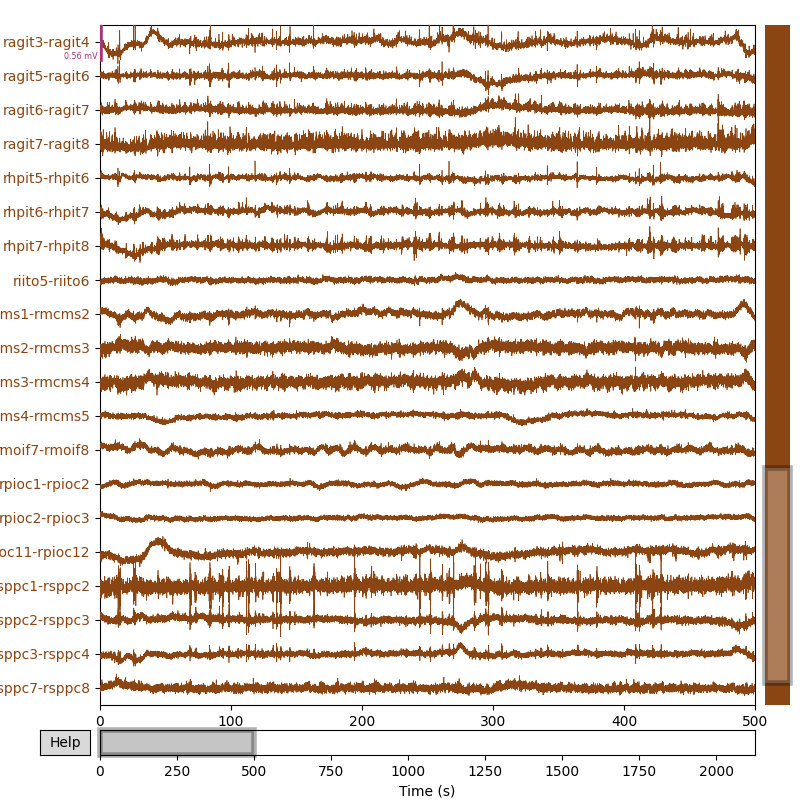

In [47]:
 %matplotlib notebook
fig = mne_data_bp_reref.plot(start=0, duration=500, n_channels=20, scalings=mne_data_bp_reref._data.max()/5)

Effective window size : 0.512 (s)


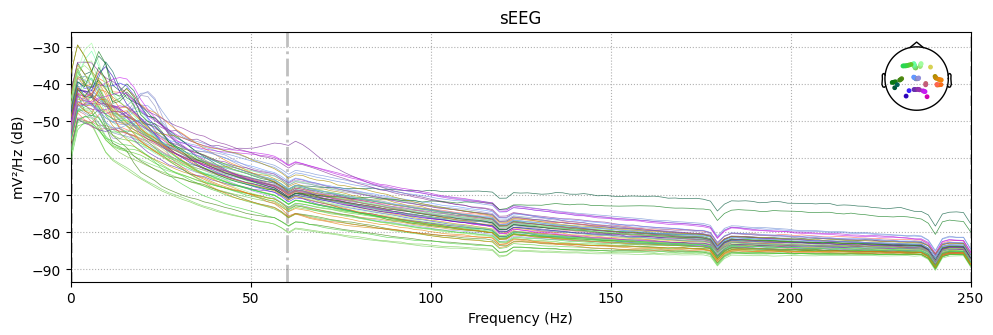

In [32]:
mne_data_bp_reref.compute_psd().plot()

In [33]:
mne_data_bp_reref.save(f'{neural_dir}{subj_id}/bp_ref_ieeg.fif',overwrite=True)

Overwriting existing file.
Writing /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS019/bp_ref_ieeg.fif
Closing /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS019/bp_ref_ieeg.fif
[done]


## Save mne_data

In [34]:
mne_data.save(f'{neural_dir}{subj_id}/raw_ieeg.fif',overwrite=True)

Overwriting existing file.
Writing /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS019/raw_ieeg.fif
Closing /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS019/raw_ieeg.fif
[done]


# Epoching + TFRs
- Check whether data is ready to be analyzed - if this step shows noise then steps above should be repeated
- Align photodiode to behavior 
- Epoch data (and mark bad epochs)
- Baseline data
- Visualize TFRs 

In [35]:
#remove mne_data from environment to save memory 
del mne_data, mne_data_bp_reref

### Photodiode Alignment

In [36]:
#load behavior data
behav_df = pd.read_csv(f'{behav_dir}{subj_id}_pt_task_data')
behav_df = behav_df[behav_df.columns.drop(list(behav_df.filter(regex='Unnamed')))]
# behav_df = behav_df[behav_df['FeedbackOnset'] != 0] #remove fail trials from behav df
beh_ts = behav_df['TrialOnset'] #timestamp that should be aligned to photodiode 
#load photodiode data
photodiode_data = mne.io.read_raw_fif(f'{neural_dir}{subj_id}/photodiode.fif', preload=True)

Opening raw data file /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS019/photodiode.fif...
Isotrak not found
    Range : 0 ... 1062499 =      0.000 ...  2124.998 secs
Ready.
Reading 0 ... 1062499  =      0.000 ...  2124.998 secs...


In [37]:
photodiode_data

<Raw | photodiode.fif, 1 x 1062500 (2125.0 s), ~8.1 MB, data loaded>

In [73]:
### Photodiode alignment
smoothSize=11
windSize=15
height=0.75

# Synchronize to the photodiode or whatever your neural sync signal is
slope, offset = sync_utils.synchronize_data(beh_ts, 
                                            photodiode_data, #
                                            smoothSize, windSize, height)

13 blocks
.............

found matches for 45 of 205 pulses


In [74]:
print(slope, offset,smoothSize,windSize,height)

1.0000011394611152 -54.75852568620667 11 15 0.75


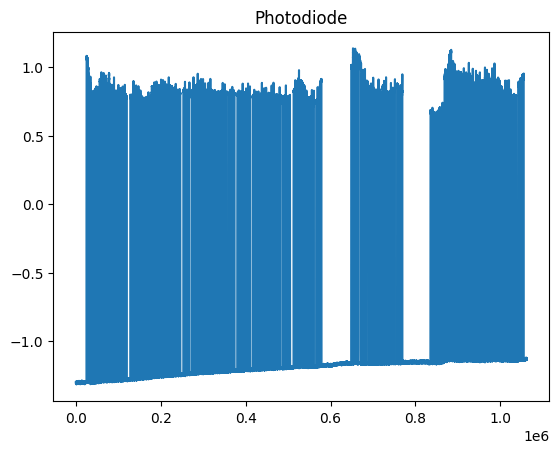

In [49]:
# Sanity check the photodiode
# plt.plot(photodiode_data._data[0,:])
plt.plot(zscore(photodiode_data._data[0,:]))
plt.title("Photodiode")
plt.show()

In [75]:

def moving_average(a, n=11) :
    """
    Computes the moving average of a given array a with a window size of n.

    Parameters
    ----------
    a : np.ndarray
        The input array to compute the moving average on.
    n : int, optional
        The window size of the moving average. Default is 11.

    Returns
    -------
    np.ndarray
        The moving average of the input array a.
    """
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

In [76]:
def get_neural_ts_photodiode(mne_sync, smoothSize=11, height=0.5):
    """
    get neural ts from photodiode
    """

    sig = np.squeeze(moving_average(mne_sync._data, n=smoothSize))
    timestamp = np.squeeze(np.arange(len(sig))/mne_sync.info['sfreq'])
    sig = scipy.stats.zscore(sig)

    trig_ix = np.where((sig[:-1]<=height)*(sig[1:]>height))[0] # rising edge of trigger
    
    neural_ts = timestamp[trig_ix]
    neural_ts = np.array(neural_ts)

    return neural_ts

In [77]:
# moving_average
neural_ts = get_neural_ts_photodiode(photodiode_data, smoothSize=15, height=0.75)
neural_ts.shape

(199,)

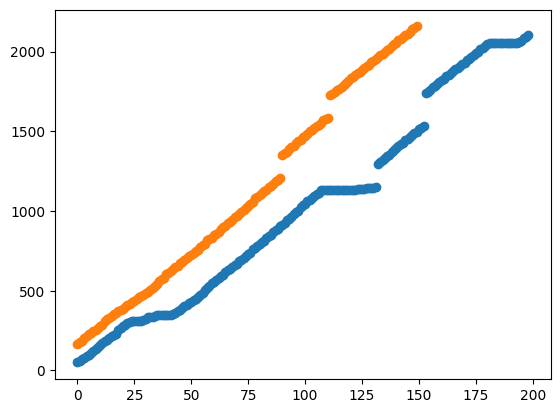

In [81]:
plt.plot(neural_ts,'o')
plt.plot(beh_ts,'o')
plt.show()

In [83]:
pulses = [(x*slope + offset) for x in beh_ts]

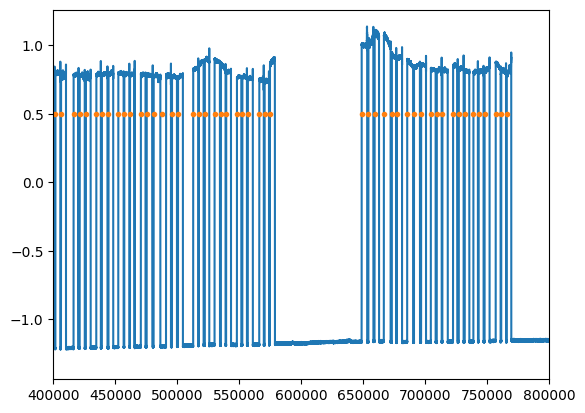

In [87]:
plt.plot(scipy.stats.zscore(photodiode_data._data[0,:]))
# plt.plot(pulses)
plt.plot(np.array(pulses)*500, 
         np.ones_like(np.array(pulses)*500)-0.5, '.')
# plt.plot(neural_ts*1024, 
#          np.ones_like(neural_ts)-0.25, '.')
plt.xlim([400000,800000])
plt.show()

In [138]:
# del epochs_all_baseline, power_epochs, plot_data

## Epoch Data
- Epoch neural data into trial epochs 
- Add behavioral data to epochs metadata
- Save epochs
- Baseline + decompose data into TFRs
- Plot + save TFRs (examine quality)

### Epoch data

In [88]:
# IED removal requires that we set some parameters for IED detection. 
# 1. peak_thresh: how many stds should they exceed the baseline by? 
# 2. closeness_thresh: how close should they be allowed to be (in sec) to other candidate IEDs? 
# 3. width_thresh: how wide should they have to be (in sec)?

# Defaults:
IED_args = {'peak_thresh':4,
           'closeness_thresh':0.25, 
           'width_thresh':0.2}

In [89]:
# Create a dictionary with your event name (matching your dataframe), and the time-window for the event
evs = {'TrialOnset': [-1.0, 0], #ITI is always at least one second + 10ms buffer for wavelet padding (no horizontal smearing)
       'DecisionOnset': [0, 5.0]} #1 sec decision period + 2 second outcome + 3 second counterfactual

In [90]:
epochs_all_evs = {f'{x}': np.nan for x in evs}

In [91]:
for event in evs.keys():
    # Make the epochs. 
    ev_epochs = lfp_preprocess_utils.make_epochs(load_path=f'{neural_dir}{subj_id}/bp_ref_ieeg.fif', 
                 slope=slope, offset=offset,
                 behav_name=event, behav_times=behav_df[event].values,downsamp_factor=None,
                 ev_start_s=evs[event][0], ev_end_s=evs[event][1], buf_s = 1.0, IED_args=IED_args) #1.0 buf unsaved

    epochs_all_evs[event] = ev_epochs
    

Opening raw data file /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS019/bp_ref_ieeg.fif...
    Range : 0 ... 1062499 =      0.000 ...  2124.998 secs
Ready.
Reading 0 ... 1062499  =      0.000 ...  2124.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 25.00
- Lower transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 21.88 Hz)
- Upper passband edge: 80.00 Hz
- Upper transition bandwidth: 20.00 Hz (-6 dB cutoff frequency: 90.00 Hz)
- Filter length: 265 samples (0.530 sec)



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done  63 out of  63 | elapsed:    3.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done  63 out of  63 | elapsed:    3.1s finished


Used Annotations descriptions: ['TrialOnset']
Not setting metadata
150 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 150 events and 1501 original time points ...
0 bad epochs dropped
Adding metadata with 63 columns
Opening raw data file /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS019/bp_ref_ieeg.fif...
    Range : 0 ... 1062499 =      0.000 ...  2124.998 secs
Ready.
Reading 0 ... 1062499  =      0.000 ...  2124.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 25.00
- Lower transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 21.88 Hz)
- Upper passband edge: 80.00 Hz
- Upper transition bandwidth: 20.00 Hz (-

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  36 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done  63 out of  63 | elapsed:    1.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done  63 out of  63 | elapsed:    2.8s finished


Used Annotations descriptions: ['DecisionOnset']
Not setting metadata
150 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 150 events and 3501 original time points ...
0 bad epochs dropped
Adding metadata with 63 columns


In [92]:
epochs_all_evs 


{'TrialOnset': <Epochs |  150 events (all good), -2 - 1 sec, baseline off, ~108.4 MB, data loaded, with metadata,
  'TrialOnset': 150>,
 'DecisionOnset': <Epochs |  150 events (all good), -1 - 6 sec, baseline off, ~252.5 MB, data loaded, with metadata,
  'DecisionOnset': 150>}

### Add behavioral data to metadata 

In [93]:
behav_params = ['TrialType','SafeBet', 'LowBet', 'HighBet','GambleChoice', 'Outcome',
       'Profit', 'TotalProfit', 'GambleEV', 'CR', 'choiceEV', 'RPE',
       'totalCPE', 'decisionCPE', 'totalRegret', 'decisionRegret',
       'totalRelief', 'decisionRelief', 'totalCF', 'decisionCF', 'pRPE',
       'nRPE']


In [94]:
for event in evs.keys():

    event_metadata = epochs_all_evs[event].metadata.copy()
    
    #independent vars
    for param in behav_params: 
        event_metadata[param] = behav_df[param].tolist()

    epochs_all_evs[event].metadata = event_metadata 
    

Replacing existing metadata with 85 columns
Replacing existing metadata with 85 columns


In [95]:
epochs_all_evs[event].metadata

,lacas1-lacas2,lacas2-lacas3,lacas3-lacas4,lacas4-lacas5,lacas5-lacas6,lacas6-lacas7,lacas7-lacas8,lacas8-lacas9,lacas9-lacas10,lagit1-lagit2,...,totalCPE,decisionCPE,totalRegret,decisionRegret,totalRelief,decisionRelief,totalCF,decisionCF,pRPE,nRPE
0,NaN,NaN,NaN,noise,NaN,NaN,NaN,NaN,NaN,NaN,...,2.75,1.65,0.00,0.00,2.75,1.65,-1.10,0.0,1.375,0.000
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.34,-0.14,-0.34,-0.14,0.00,0.00,0.00,-0.2,0.000,-0.170
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[136.602],...,-2.50,-2.00,-2.50,-2.00,0.00,0.00,0.00,-0.5,0.000,-1.250
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.66,0.36,0.00,0.00,0.66,0.36,-0.30,0.0,0.330,0.000
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.30,-0.30,-0.30,-0.30,0.00,0.00,0.00,0.0,0.000,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.20,0.60,0.00,0.00,1.20,0.60,-1.20,-0.6,0.600,0.000
146,NaN,NaN,NaN,noise,NaN,NaN,NaN,NaN,NaN,NaN,...,-1.49,-0.60,-1.49,-0.60,0.00,0.00,1.49,0.6,0.000,-0.745
147,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-1.50,-0.30,-1.50,-0.30,0.00,0.00,1.50,0.3,0.000,-0.750
148,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-1.90,-0.60,-1.90,-0.60,0.00,0.00,1.90,0.6,0.000,-0.950


### Save raw epoched data 

In [96]:
for event in evs.keys():
    epochs_all_evs[event].save(f'{neural_dir}{subj_id}/bp_epoch_{event}.fif', overwrite=True)

Overwriting existing file.
Overwriting existing file.


### Baseline + Decompose into TFRs

In [97]:
# Explicitly define a list of analysis events and the baseline event. Should correspond to the dict
analysis_evs = ['DecisionOnset']
baseline_ev = 'TrialOnset'
evs = {'TrialOnset': [-1.0, 0], #maybe increase to full second to take cycles up to 4
       #ITI is always at least one second + 10ms buffer for wavelet padding (no horizontal smearing)
       'DecisionOnset': [0, 5.0]} #1 sec decision period + 2 second outcome + 3 second counterfactual

In [98]:
# Set some spectrogram parameters 
freqs = np.logspace(*np.log10([2, 200]), num=30)
n_cycles = np.floor(np.logspace(*np.log10([3, 10]), num=30))


In [99]:
epochs_all_baseline = {} #removed unecessary 'decisiononset' empty key

In [100]:
#baseline epoch - 
event = 'TrialOnset' #or baseline_ev
epochs = epochs_all_evs[event]

good_chans = [x for x in epochs.ch_names if x not in epochs.info['bads']]
picks = [x for x in good_chans]

pow_struct = np.nan * np.ones([epochs._data.shape[0], 
                       epochs._data.shape[1], len(freqs), 
                       epochs._data.shape[-1]])

### this is new!
good_epochs, bad_epochs = lfp_preprocess_utils.get_bad_epochs_by_chan(epochs)

for ch_ix, ch_name in enumerate(epochs.ch_names): 
    ch_data = epochs._data[:, ch_ix:ch_ix+1, :]
    ch_data = np.delete(ch_data, bad_epochs[ch_name], axis=0)
    ch_pow = mne.time_frequency.tfr_array_morlet(ch_data, sfreq=epochs.info['sfreq'], 
                                         freqs=freqs, n_cycles=n_cycles, zero_mean=False, 
                                        use_fft=True, output='power', n_jobs=-1)

    pow_struct[good_epochs[ch_name], ch_ix, :, :] = ch_pow[:, 0, :, :]


temp_pow = mne.time_frequency.EpochsTFR(epochs.info, pow_struct, 
                                        epochs.times, freqs)
temp_pow.crop(tmin=evs[event][0], tmax=evs[event][1])

epochs_all_baseline[event] = temp_pow


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1

[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Not setting metadata


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


In [101]:
epochs_all_baseline

{'TrialOnset': <EpochsTFR | time : [-1.000000, 0.000000], freq : [2.000000, 200.000000], epochs : 150, channels : 63, ~1.06 GB>}

In [102]:
power_epochs = {}

In [103]:
event = 'DecisionOnset' # or analysis_evs

epochs = epochs_all_evs[event]

ch_names = epochs.ch_names

# Let's make sure we only do this for good channels
good_chans = [x for x in epochs.ch_names if x not in epochs.info['bads']]
picks = [x for x in good_chans]

pow_struct = np.nan * np.ones([epochs._data.shape[0], 
                       epochs._data.shape[1], len(freqs), 
                       epochs._data.shape[-1]])

good_epochs, bad_epochs = lfp_preprocess_utils.get_bad_epochs_by_chan(epochs)

for ch_ix, ch_name in enumerate(epochs.ch_names):
    ch_data = epochs._data[:, ch_ix:ch_ix+1, :]
    ch_data = np.delete(ch_data, bad_epochs[ch_name], axis=0) #this is where bad epochs for ch are deleted!!
    ch_pow = mne.time_frequency.tfr_array_morlet(ch_data, sfreq=epochs.info['sfreq'], 
                                        freqs=freqs, n_cycles=n_cycles, zero_mean=False, 
                                        use_fft=True, output='power', n_jobs=-1)

    pow_struct[good_epochs[ch_name], ch_ix, :, :] = ch_pow[:, 0, :, :]

temp_pow = mne.time_frequency.EpochsTFR(epochs.info, pow_struct, 
                                        epochs.times, freqs)

temp_pow.crop(tmin=evs[event][0], tmax=evs[event][1])


baseline_corrected_power = lfp_preprocess_utils.baseline_trialwise_TFR(data=temp_pow.data, 
                                                  baseline_mne=epochs_all_baseline['TrialOnset'].data, 
                                                  mode='zscore',ev_axis=0,elec_axis=1,
                                                  freq_axis=2,time_axis=3)


zpow = mne.time_frequency.EpochsTFR(epochs.info, baseline_corrected_power, 
                                temp_pow.times, freqs)

zpow.metadata = epochs_all_evs[event].metadata

power_epochs[event] = zpow



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1

[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Not setting metadata


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.8s finished


Not setting metadata
Adding metadata with 85 columns


In [104]:
power_epochs['DecisionOnset']

<EpochsTFR | time : [0.000000, 5.000000], freq : [2.000000, 200.000000], epochs : 150, channels : 63, ~5.28 GB>

In [105]:
#conda install -c conda-forge h5io must install to save tfr data
power_epochs['DecisionOnset'].save(f'{neural_dir}{subj_id}/bp_pow_epochs-tfr.h5', overwrite=True)


## Plot TFRs

In [106]:
####add directory for TFRs
tfr_dir = f'{base_dir}ephys_analysis/figs/TFRs/{subj_id}/all_trials/'
os.makedirs(tfr_dir,exist_ok = True) #added so you don't have to manually make subject folders in clean_data
date = datetime.date.today().strftime('%m%d%Y')

print(date)
# mne_data_bp_reref = mne.io.read_raw_fif(f'{neural_dir}{subj_id}/bp_ref_ieeg.fif',preload=True)

04072024


In [140]:
#to reload for more cleaning if necessary
# mne_data_bp_reref = mne.io.read_raw_fif(f'{neural_dir}{subj_id}/bp_ref_ieeg.fif',preload=True)
# mne_data = mne.io.read_raw_fif(f'{neural_dir}{subj_id}/raw_ieeg.fif',preload=True)

In [107]:
event = 'DecisionOnset'
good_ch = [x for x in power_epochs[event].ch_names if '-' in x]
save_path = tfr_dir

print(offset)


for ch in good_ch:
    fig, ax = plt.subplots(1, 1, figsize=(6, 4))
    # same for all elec
    times = power_epochs[event].times
    # single ch tfr 
    plot_data = np.nanmean(np.nanmean(power_epochs[event].copy().pick_channels([ch]).data, axis=0), axis=0)

    im = ax.imshow(plot_data,interpolation='Bicubic',
            aspect='auto', origin='lower', cmap='RdBu_r',vmin = -np.nanmax(np.abs(plot_data)), 
                   vmax = np.nanmax(np.abs(plot_data)))
    

    ax.set(xlabel='Time (s)', ylabel='Frequency',title=f'{ch} Encoding',
           yticks=np.arange(0,len(freqs))[::5], 
           yticklabels=freqs[::5].astype(int), 
           xticks = np.arange(plot_data.shape[1])[::250],
              xticklabels= times[::250])
    fig.colorbar(im, ax=ax)
    
    plt.savefig(f'{save_path}/{ch}_{date}_bp_ref.png', format='png', metadata=None,
    bbox_inches=None, pad_inches=0.1,
    facecolor='auto', edgecolor='auto',
    backend=None)
    plt.close()


-54.75852568620667
